# **💁🏻🗨️💁🏻‍♂️대화 요약 EDA code**
> **Dialogue Summarization**  🎉    
> Dialogue, Summary 길이 확인.     
> 이상 데이터 확인 및 처리?

## ⚙️ 데이터 및 환경설정

### 1) 필요한 라이브러리 설치

- 필요한 라이브러리를 설치한 후 불러옵니다.

In [1]:
import pandas as pd
import os
import re
import json
import yaml
from glob import glob
from tqdm import tqdm
from pprint import pprint
import torch
import pytorch_lightning as pl
from rouge import Rouge # 모델의 성능을 평가하기 위한 라이브러리입니다.

from torch.utils.data import Dataset , DataLoader
from transformers import AutoTokenizer, BartForConditionalGeneration, BartConfig
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import Trainer, TrainingArguments
from transformers import EarlyStoppingCallback

import wandb # 모델 학습 과정을 손쉽게 Tracking하고, 시각화할 수 있는 라이브러리입니다.

### 2) Config file 만들기 (선택)
- 모델 생성에 필요한 다양한 매개변수 정보를 저장할 수 있습니다.  
  따라서, 코드 상에서 모델의 매개변수를 설정할 수도 있지만 독립적인 매개변수 정보 파일을 생성하여 관리할 수 있습니다.

In [2]:
# config 설정에 tokenizer 모듈이 사용되므로 미리 tokenizer를 정의해줍니다.
tokenizer = AutoTokenizer.from_pretrained("digit82/kobart-summarization")

In [3]:
config_data = {
    "general": {
        "data_path": "../data/", # 모델 생성에 필요한 데이터 경로를 사용자 환경에 맞게 지정합니다.
        "model_name": "digit82/kobart-summarization", # 불러올 모델의 이름을 사용자 환경에 맞게 지정할 수 있습니다.
        "output_dir": "./" # 모델의 최종 출력 값을 저장할 경로를 설정합니다.
    },
    "tokenizer": {
        "encoder_max_len": 512,
        "decoder_max_len": 100,
        "bos_token": f"{tokenizer.bos_token}",
        "eos_token": f"{tokenizer.eos_token}",
        # 특정 단어들이 분해되어 tokenization이 수행되지 않도록 special_tokens을 지정해줍니다.
        "special_tokens": ['#Person1#', '#Person2#', '#Person3#', '#PhoneNumber#', '#Address#', '#PassportNumber#']
    },
    "training": {
        "overwrite_output_dir": True,
        "num_train_epochs": 20,
        "learning_rate": 1e-5,
        "per_device_train_batch_size": 50,
        "per_device_eval_batch_size": 32,
        "warmup_ratio": 0.1,
        "weight_decay": 0.01,
        "lr_scheduler_type": 'cosine',
        "optim": 'adamw_torch',
        "gradient_accumulation_steps": 1,
        "evaluation_strategy": 'epoch',
        "save_strategy": 'epoch',
        "save_total_limit": 5,
        "fp16": True,
        "load_best_model_at_end": True,
        "seed": 42,
        "logging_dir": "./logs",
        "logging_strategy": "epoch",
        "predict_with_generate": True,
        "generation_max_length": 100,
        "do_train": True,
        "do_eval": True,
        "early_stopping_patience": 3,
        "early_stopping_threshold": 0.001,
        "report_to": "wandb" # (선택) wandb를 사용할 때 설정합니다.
    },
    # (선택) wandb 홈페이지에 가입하여 얻은 정보를 기반으로 작성합니다.
    "wandb": {
        "entity": "ktbaek",
        "project": "NLP-project",
        "name": "BaseLineCode-1"
    },
    "inference": {
        "ckt_path": "./ckt/", # 사전 학습이 진행된 모델의 checkpoint를 저장할 경로를 설정합니다.
        "result_path": "./prediction/",
        "no_repeat_ngram_size": 2,
        "early_stopping": True,
        "generate_max_length": 100,
        "num_beams": 4,
        "batch_size" : 32,
        # 정확한 모델 평가를 위해 제거할 불필요한 생성 토큰들을 정의합니다.
        "remove_tokens": ['<usr>', f"{tokenizer.bos_token}", f"{tokenizer.eos_token}", f"{tokenizer.pad_token}"]
    }
}

- 참고✅    
: wandb 라이브러리를 사용하기 위해선 entity, project, name를 지정해주어야 합니다. wandb 홈페이지에 가입한 후 얻은 정보를 입력하여 작동할 수 있습니다.

In [4]:
# 모델의 구성 정보를 YAML 파일로 저장합니다.
config_path = "./config.yaml"
with open(config_path, "w") as file:
    yaml.dump(config_data, file, allow_unicode=True)

### 3) Configuration 불러오기

In [5]:
# 저장된 config 파일을 불러옵니다.
config_path = "./config.yaml"

with open(config_path, "r") as file:
    loaded_config = yaml.safe_load(file)

# 불러온 config 파일의 전체 내용을 확인합니다.
pprint(loaded_config)

{'general': {'data_path': '../data/',
             'model_name': 'digit82/kobart-summarization',
             'output_dir': './'},
 'inference': {'batch_size': 32,
               'ckt_path': './ckt/',
               'early_stopping': True,
               'generate_max_length': 100,
               'no_repeat_ngram_size': 2,
               'num_beams': 4,
               'remove_tokens': ['<usr>', '<s>', '</s>', '<pad>'],
               'result_path': './prediction/'},
 'tokenizer': {'bos_token': '<s>',
               'decoder_max_len': 100,
               'encoder_max_len': 512,
               'eos_token': '</s>',
               'special_tokens': ['#Person1#',
                                  '#Person2#',
                                  '#Person3#',
                                  '#PhoneNumber#',
                                  '#Address#',
                                  '#PassportNumber#']},
 'training': {'do_eval': True,
              'do_train': True,
              'early_s

In [6]:
# 실험에 쓰일 데이터의 경로, 사용될 모델, 모델의 최종 출력 결과를 저장할 경로에 대해 확인합니다.
loaded_config['general']

{'data_path': '../data/',
 'model_name': 'digit82/kobart-summarization',
 'output_dir': './'}

In [7]:
# 이곳에 사용자가 저장한 데이터 dir 설정하기
# loaded_config['general']['data_path'] = "data_path"

In [8]:
# 데이터 전처리를 하기 위해 tokenization 과정에서 필요한 정보들을 확인합니다.
loaded_config['tokenizer']

{'bos_token': '<s>',
 'decoder_max_len': 100,
 'encoder_max_len': 512,
 'eos_token': '</s>',
 'special_tokens': ['#Person1#',
  '#Person2#',
  '#Person3#',
  '#PhoneNumber#',
  '#Address#',
  '#PassportNumber#']}

In [9]:
# 모델이 훈련 시 적용될 매개변수를 확인합니다.
loaded_config['training']

{'do_eval': True,
 'do_train': True,
 'early_stopping_patience': 3,
 'early_stopping_threshold': 0.001,
 'evaluation_strategy': 'epoch',
 'fp16': True,
 'generation_max_length': 100,
 'gradient_accumulation_steps': 1,
 'learning_rate': 1e-05,
 'load_best_model_at_end': True,
 'logging_dir': './logs',
 'logging_strategy': 'epoch',
 'lr_scheduler_type': 'cosine',
 'num_train_epochs': 20,
 'optim': 'adamw_torch',
 'overwrite_output_dir': True,
 'per_device_eval_batch_size': 32,
 'per_device_train_batch_size': 50,
 'predict_with_generate': True,
 'report_to': 'wandb',
 'save_strategy': 'epoch',
 'save_total_limit': 5,
 'seed': 42,
 'warmup_ratio': 0.1,
 'weight_decay': 0.01}

In [10]:
# 모델 학습 과정에 대한 정보를 제공해주는 wandb 설정 내용을 확인합니다.
loaded_config['wandb']

{'entity': 'ktbaek', 'name': 'BaseLineCode-1', 'project': 'NLP-project'}

In [11]:
# (선택) 이곳에 사용자가 사용할 wandb config 설정
# loaded_config['wandb']['entity'] = "ktbaek"
# loaded_config['wandb']['name'] = "BaseLineCode-1"
# loaded_config['wandb']['project'] = "NLP-project"

In [11]:
# 모델이 최종 결과를 출력하기 위한 매개변수 정보를 확인합니다.
loaded_config['inference']

{'batch_size': 32,
 'ckt_path': './ckt/',
 'early_stopping': True,
 'generate_max_length': 100,
 'no_repeat_ngram_size': 2,
 'num_beams': 4,
 'remove_tokens': ['<usr>', '<s>', '</s>', '<pad>'],
 'result_path': './prediction/'}

### 4) 데이터 불러와서 확인해보기
- 실험에서 쓰일 데이터를 load하여 데이터의 구조와 내용을 살펴보겠습니다.
- Train, dev, test 순서대로 12457, 499, 250개 씩 데이터가 구성되어 있습니다.

In [12]:
# config에 저장된 데이터 경로를 통해 train과 validation data를 불러옵니다.
data_path = loaded_config['general']['data_path']

# train data의 구조와 내용을 확인합니다.
train_df = pd.read_csv(os.path.join(data_path,'train.csv'))
train_df.tail()

,fname,dialogue,summary,topic
12452,train_12455,#Person1#: 실례합니다. 맨체스터 출신의 그린 씨이신가요?\n#Person2...,탄 링은 흰머리와 수염으로 쉽게 인식되는 그린 씨를 만나 호텔로 데려갈 예정입니다....,누군가를 태우다
12453,train_12456,#Person1#: 이윙 씨가 우리가 컨퍼런스 센터에 오후 4시에 도착해야 한다고 ...,#Person1#과 #Person2#는 이윙 씨가 늦지 않도록 요청했기 때문에 컨퍼...,컨퍼런스 센터
12454,train_12457,#Person1#: 오늘 어떻게 도와드릴까요?\n#Person2#: 차를 빌리고 싶...,#Person2#는 #Person1#의 도움으로 5일 동안 소형 차를 빌립니다.,차 렌트
12455,train_12458,#Person1#: 오늘 좀 행복해 보이지 않아. 무슨 일 있어?\n#Person2...,#Person2#의 엄마가 일자리를 잃었다. #Person2#는 엄마가 우울해하지 ...,실직
12456,train_12459,"#Person1#: 엄마, 다음 토요일에 이 삼촌네 가족을 방문하기 위해 비행기를 ...",#Person1#은 다음 토요일에 이 삼촌네를 방문할 때 가방을 어떻게 싸야 할지 ...,짐 싸기


In [13]:
# validation data의 구조와 내용을 확인합니다.
val_df = pd.read_csv(os.path.join(data_path,'dev.csv'))
val_df.tail()

,fname,dialogue,summary,topic
494,dev_495,#Person1#: 이제 새해가 되어서 새로운 시작을 하려고 결심했어. \r\n#P...,#Person1#은 새해에 금연을 하고 커밍아웃하기로 결정했습니다. #Person2...,새해
495,dev_496,"#Person1#: 너, 조랑 결혼했지? \r\n#Person2#: 조? 무슨 말인...",#Person1#은 #Person2#가 조와 결혼했다고 생각했다. #Person2#...,사랑에 빠지다
496,dev_497,"#Person1#: 무엇을 도와드릴까요, 부인?\r\n#Person2#: 몇 주 동...",#Person2#의 차에서 이상한 소리가 납니다. #Person1#는 브레이크를 교...,소음
497,dev_498,"#Person1#: 안녕하세요, 아마존 고객 서비스입니다. 무엇을 도와드릴까요?\n...",#Person2#님이 아마존 고객 서비스에 전화하여 아마존에서 받은 책에 한 페이지...,빠진 페이지
498,dev_499,#Person1#: 여름이 다 되어간다는 게 믿기지 않아.\r\n#Person2#:...,#Person2#는 #Person1#에게 여름 휴가 동안 파티를 도와주는 회사에서 ...,여름 휴가


In [14]:
tt = train_df['summary']
print(max(tt.str.len()))
cnt = pd.DataFrame(tt.str.len().value_counts())
new_cnt = cnt.reset_index()
new_cnt

478


,summary,count
0,63,179
1,76,177
2,73,174
3,74,174
4,59,174
...,...,...
254,351,1
255,254,1
256,388,1
257,303,1


In [10]:
%pip install matplotlib

  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/8d/9d/d06860390f9d154fa884f1740a5456378fb153ff57443c91a4a32bab7092/matplotlib-3.9.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/99/e6/d11966962b1aa515f5586d3907ad019f4b812c04e4546cc19ebf62b5178e/contourpy-1.3.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for cycler>=0.10 from https://files.pythonhosted.org/packages/e7/05/c19819d5e3d95294a6f5947fb9b9629efb316b96de511b418c53d245aae6/cycler-0.12.1-py3-none-any.whl.metadata
  Obtaining dependency information for fonttools>=4.22.0 from https://files.pythonhosted.org/packages/56/61/ad19cad430aacbc3418be503e1f6daed9375c997a4e32b78a91195b3054a/fonttools-4.53.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

(array([[  0.,  13.,  16.,  16.,  16.,  16.,  16.,  16.,  16.,  15.,  16.,
          16.,  16.,  15.,  12.,  12.,   7.,   7.,   6.,   0.,   4.,   0.,
           3.,   0.,   2.,   0.,   2.,   0.,   0.,   1.],
        [128.,  22.,  17.,  10.,   9.,  11.,  11.,  11.,  17.,  15.,   6.,
           2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]]),
 array([  1. ,  16.9,  32.8,  48.7,  64.6,  80.5,  96.4, 112.3, 128.2,
        144.1, 160. , 175.9, 191.8, 207.7, 223.6, 239.5, 255.4, 271.3,
        287.2, 303.1, 319. , 334.9, 350.8, 366.7, 382.6, 398.5, 414.4,
        430.3, 446.2, 462.1, 478. ]),
 <a list of 2 BarContainer objects>)

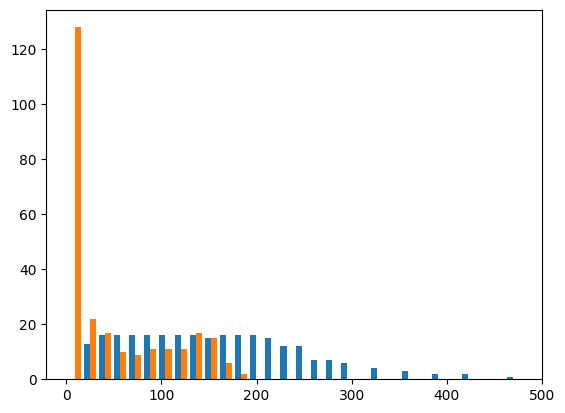

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(new_cnt, bins=30)

In [13]:
dtt = train_df['dialogue']
print(max(dtt.str.len()))
dcnt = pd.DataFrame(dtt.str.len().value_counts())
new_dcnt = dcnt.reset_index()
new_dcnt

2546


,dialogue,count
0,350,52
1,362,49
2,316,48
3,352,48
4,337,43
...,...,...
1071,983,1
1072,1074,1
1073,1834,1
1074,1079,1


(array([[0.000e+00, 6.900e+01, 8.500e+01, 8.500e+01, 8.500e+01, 8.400e+01,
         8.500e+01, 8.500e+01, 8.500e+01, 8.400e+01, 6.900e+01, 6.000e+01,
         4.600e+01, 3.400e+01, 2.200e+01, 2.100e+01, 2.000e+01, 1.300e+01,
         7.000e+00, 1.100e+01, 4.000e+00, 4.000e+00, 3.000e+00, 4.000e+00,
         3.000e+00, 2.000e+00, 3.000e+00, 2.000e+00, 0.000e+00, 1.000e+00],
        [1.076e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]]),
 array([1.00000000e+00, 8.58333333e+01, 1.70666667e+02, 2.55500000e+02,
        3.40333333e+02, 4.25166667e+02, 5.10000000e+02, 5.94833333e+02,
        6.79666667e+02, 7.64500000e+02, 8.49333333e+02, 9.34166667e+02,
        1.01900000e+03, 1.1038

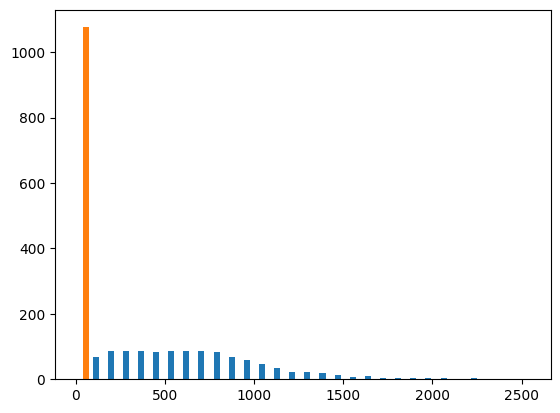

In [14]:
plt.hist(new_dcnt, bins=30)

valid data

In [15]:
vv = val_df['summary']
print(max(vv.str.len()))
vcnt = pd.DataFrame(vv.str.len().value_counts())
new_vcnt = vcnt.reset_index()
new_vcnt

263


,summary,count
0,65,13
1,54,12
2,55,12
3,74,12
4,56,11
...,...,...
127,166,1
128,35,1
129,137,1
130,145,1


(array([[  0.,   0.,   2.,   6.,   9.,   9.,   9.,   8.,   9.,   9.,   9.,
           8.,   9.,   7.,   4.,   8.,   6.,   4.,   4.,   3.,   1.,   2.,
           2.,   1.,   0.,   0.,   0.,   0.,   1.,   2.],
        [125.,   7.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]]),
 array([  1.        ,   9.73333333,  18.46666667,  27.2       ,
         35.93333333,  44.66666667,  53.4       ,  62.13333333,
         70.86666667,  79.6       ,  88.33333333,  97.06666667,
        105.8       , 114.53333333, 123.26666667, 132.        ,
        140.73333333, 149.46666667, 158.2       , 166.93333333,
        175.66666667, 184.4       , 193.13333333, 201.86666667,
        210.6       , 219.33333333, 228.06666667, 236.8       ,
        245.53333333, 254.26666667, 263.        ]),
 <a list of 2 BarContainer objects>)

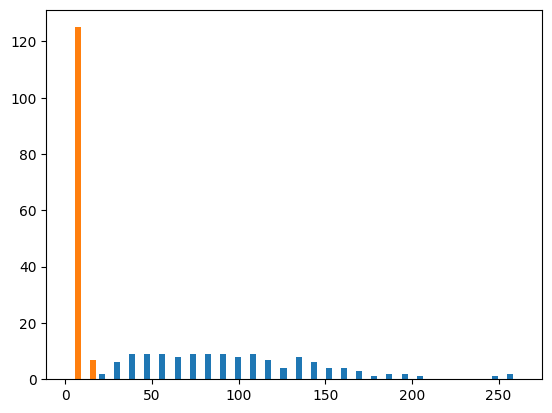

In [16]:
plt.hist(new_vcnt, bins=30)

In [17]:
vdtt = val_df['dialogue']
print(max(vdtt.str.len()))
vdcnt = pd.DataFrame(vdtt.str.len().value_counts())
new_vdcnt = vdcnt.reset_index()
new_vdcnt

1484


,dialogue,count
0,328,4
1,347,4
2,309,4
3,457,4
4,346,4
...,...,...
348,225,1
349,194,1
350,143,1
351,367,1


(array([[  0.,   0.,   7.,  31.,  21.,  31.,  41.,  36.,  29.,  27.,  30.,
          19.,  14.,  17.,  14.,   8.,   6.,   6.,   4.,   1.,   4.,   1.,
           2.,   2.,   0.,   0.,   0.,   1.,   0.,   1.],
        [353.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]]),
 array([1.00000000e+00, 5.04333333e+01, 9.98666667e+01, 1.49300000e+02,
        1.98733333e+02, 2.48166667e+02, 2.97600000e+02, 3.47033333e+02,
        3.96466667e+02, 4.45900000e+02, 4.95333333e+02, 5.44766667e+02,
        5.94200000e+02, 6.43633333e+02, 6.93066667e+02, 7.42500000e+02,
        7.91933333e+02, 8.41366667e+02, 8.90800000e+02, 9.40233333e+02,
        9.89666667e+02, 1.03910000e+03, 1.08853333e+03, 1.13796667e+03,
        1.18740000e+03, 1.23683333e+03, 1.28626667e+03, 1.33570000e+03,
        1.38513333e+03, 1.43456667e+03, 1.48400000e+03]),
 <a list of 2 BarCon

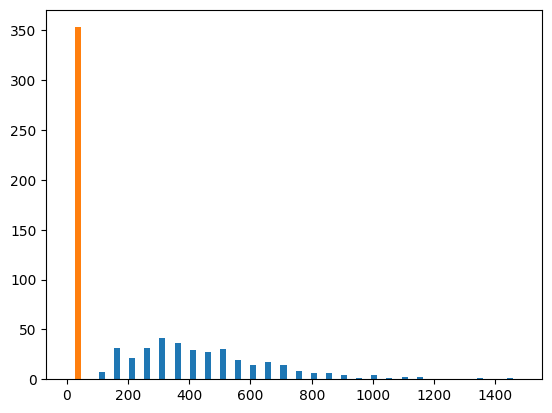

In [18]:
plt.hist(new_vdcnt, bins=30)

## 데이터 길이 확인 후 결정 2024.08.31
dialogue max 길이 : 1500

summary max 길이 : 250

In [ ]:
512
100

성능 나쁘지 않음


In [19]:
train_df.describe()

,fname,dialogue,summary,topic
count,12457,12457,12457,12457
unique,12457,12419,12441,6526
top,train_0,"#Person1#: 그래서, 수잔, 이번 토요일에 계획이 있나요?\n#Person2...",#Person1#은 자신이 MP3 플레이어와 스테레오 헤드폰을 가지고 있기 때문에 ...,일상 대화
freq,1,2,3,236


## special tokens

In [20]:
special_token_list = []

pattern = r"#[a-zA-Z\d\s]*#"

for dialogue in train_df["dialogue"]:
    sp_token = re.findall(pattern, dialogue)
    
    special_token_list += sp_token
    special_token_list = list(set(special_token_list))

In [21]:
special_token_list

['#DateOfBirth#',
 '#Person5#',
 '#Address#',
 '#Email#',
 '#Person3#',
 '#Person4#',
 '#PassportNumber#',
 '#Person6#',
 '##',
 '#Person#',
 '#PhoneNumber#',
 '#CarNumber#',
 '#Person 2#',
 '#Person7#',
 '#SSN#',
 '#Person1#',
 '#Person2#',
 '#CardNumber#']

In [40]:
import time
from IPython.display import clear_output 



for i in range(len(val_df)):
    clear_output(wait=True)
    print(f'val_data:\n{val_df["dialogue"][i]}')
    time.sleep(2)

val_data:
#Person1#: ATM 카드는 어떻게 사용하나요, 빌리?
#Person2#: 쉽습니다, 할아버지. 카드를 여기 기계에 넣으세요. 잠시 기다리세요. 좋아요. 이제 PIN 번호를 입력하세요. 네 자리 숫자여야 합니다.
#Person1#: 아, 그렇군요. 여기 적어 놓았어요. 잠시만요.
#Person2#: 정말로 적어두지 않는 게 좋습니다. 외워야 합니다. 원하시면 더 편리한 번호로 변경할 수도 있습니다.
#Person1#: 알겠습니다, PIN 번호를 입력했어요. 화면에 여러 가지 옵션이 있네요. 제가 원하는 서비스를 선택하면 되는 거죠?
#Person2#: 네, 사용하려는 서비스를 선택하세요. 현금을 인출하려면 기계가 얼마나 원하는지 물어볼 겁니다.
#Person1#: 그럼 키를 이용해서 금액을 입력하면 되는 거죠?
#Person2#: 맞습니다. 기계가 요청을 처리하는 데 잠시 시간이 걸립니다. 그런 다음 돈을 가져가세요.
#Person1#: 이 기계들은 사용하기가 그리 어렵지 않네요. 사실, 나는 꽤 좋아합니다. 은행 직원과 거래하는 것보다 훨씬 빠르네요.


KeyboardInterrupt: 

In [45]:
import time
from IPython.display import clear_output 



for i in range(len(train_df)-1245):
    clear_output(wait=True)
    print(f'val_data:\n{train_df["dialogue"][i]}')
    time.sleep(2)

val_data:
#Person1#: 주문하시겠습니까?
#Person2#: 아직 결정하지 못했습니다. 조금 더 시간을 주실 수 있나요?
#Person1#: 네, 천천히 결정하셔도 됩니다.
#Person2#: 먼저 음료를 가져다 주실 수 있나요? 맥주 두 병을 원합니다.
#Person1#: 알겠습니다.
#Person2#: 오늘의 특선 메뉴를 알려주실 수 있나요?
#Person1#: 오늘의 특선 메뉴는 스테이크입니다.
#Person2#: 그럼 이 스테이크 디너를 주문하겠습니다.
#Person1#: 스테이크와 함께 드실 것은 무엇인가요?
#Person2#: 완두콩과 당근입니다.
#Person1#: 알겠습니다. 디저트로 무엇을 드시겠습니까?
#Person2#: 아이스크림 부탁드립니다.


KeyboardInterrupt: 

In [41]:
len(train_df)

12457

In [47]:
print(train_df["dialogue"][1125])

사람1#: 제니, 이번 금요일에, 음... 바쁘세요?
#Person2#: 네, 금요일에는 일 끝나고 바로 수업이 있어요.
#Person1#: 그렇군요. 그럼 토요일은 어때요? 그날 시간 있으세요?
#Person2#: 토요일에는 부모님이 오시려고 해요. 왜요?
#Person1#: 그럼 오늘은요? 오늘은 다른 계획이 있으세요?
#Person2#: 아니요. 뭔가 하려고 했어요?
#Person1#: 네! 네! 저녁에 식사 대접하려고 했어요.
#Person2#: 오! 좋아요! 여섯 시에 어떠세요?


In [53]:
# df = train_df["dialogue"][1125]
train_df['dialogue'] = train_df['dialogue'].apply(lambda x:x.replace('사람1#', '#Person1#'))
train_df["dialogue"][1125]

'#Person1#: 제니, 이번 금요일에, 음... 바쁘세요?\r\n#Person2#: 네, 금요일에는 일 끝나고 바로 수업이 있어요.\r\n#Person1#: 그렇군요. 그럼 토요일은 어때요? 그날 시간 있으세요?\r\n#Person2#: 토요일에는 부모님이 오시려고 해요. 왜요?\r\n#Person1#: 그럼 오늘은요? 오늘은 다른 계획이 있으세요?\r\n#Person2#: 아니요. 뭔가 하려고 했어요?\r\n#Person1#: 네! 네! 저녁에 식사 대접하려고 했어요.\r\n#Person2#: 오! 좋아요! 여섯 시에 어떠세요?'

#### EDA 2024.9.5

In [15]:
# dialog 와 summary 각각의 모델 max_length 설정을 위한 길이 확인

train_dialog_length = train_df['dialogue'].apply(lambda x:len(x))
train_summary_length = train_df['summary'].apply(lambda x:len(x))

print("대화 길이에 대한 정보")
print(train_dialog_length.describe())
print("=================")
print("요약문 길이에 대한 정보")
print(train_summary_length.describe())

대화 길이에 대한 정보
count    12457.000000
mean       438.765112
std        220.134710
min         99.000000
25%        299.000000
50%        396.000000
75%        540.000000
max       2546.000000
Name: dialogue, dtype: float64
요약문 길이에 대한 정보
count    12457.000000
mean        87.397929
std         37.641178
min         19.000000
25%         61.000000
50%         80.000000
75%        106.000000
max        478.000000
Name: summary, dtype: float64


In [16]:
# dialog 와 summary 각각의 모델 max_length 설정을 위한 길이 확인

val_dialog_length = val_df['dialogue'].apply(lambda x:len(x))
val_summary_length = val_df['summary'].apply(lambda x:len(x))

print("대화 길이에 대한 정보")
print(val_dialog_length.describe())
print("=================")
print("요약문 길이에 대한 정보")
print(val_summary_length.describe())

대화 길이에 대한 정보
count     499.000000
mean      432.559118
std       206.074045
min       132.000000
25%       299.000000
50%       392.000000
75%       526.000000
max      1484.000000
Name: dialogue, dtype: float64
요약문 길이에 대한 정보
count    499.000000
mean      81.709419
std       35.877381
min       25.000000
25%       55.000000
50%       74.000000
75%       98.000000
max      263.000000
Name: summary, dtype: float64


In [17]:
# 정규표현식 사용하기 
import re
def reg_masking(text):
  pattern = r"#\w+#"  # ## 사이의 값을 추출하는 정규식 패턴
  masked = re.findall(pattern, text)
  return masked

train_set = train_df['dialogue'].apply(lambda x:str(set(reg_masking(x))))

In [18]:
train_set

0        {'#Person1#', '#Person2#'}
1        {'#Person1#', '#Person2#'}
2        {'#Person1#', '#Person2#'}
3        {'#Person1#', '#Person2#'}
4        {'#Person1#', '#Person2#'}
                    ...            
12452    {'#Person1#', '#Person2#'}
12453    {'#Person1#', '#Person2#'}
12454    {'#Person1#', '#Person2#'}
12455    {'#Person1#', '#Person2#'}
12456    {'#Person1#', '#Person2#'}
Name: dialogue, Length: 12457, dtype: object

In [23]:
import re
def reg_person(text):
  pattern = r"#\w+\d#"  # ## 사이의 값을 추출하는 정규식 패턴 > special token 으로 tokenizer에 추가
  masked = re.findall(pattern, text)
  print(masked)
  return masked

train_person = train_df['dialogue'].apply(lambda x:set(reg_person(x)))

train_person

['#Person1#', '#Person2#', '#Person1#', '#Person2#', '#Person1#', '#Person2#', '#Person1#', '#Person2#', '#Person1#', '#Person2#', '#Person1#', '#Person2#']
['#Person1#', '#Person2#', '#Person1#', '#Person2#', '#Person1#', '#Person2#', '#Person1#']
['#Person1#', '#Person2#', '#Person1#', '#Person2#', '#Person1#', '#Person2#', '#Person1#', '#Person2#', '#Person1#', '#Person2#']
['#Person1#', '#Person2#', '#Person1#', '#Person2#', '#Person1#', '#Person2#', '#Person1#', '#Person2#', '#Person1#', '#Person2#', '#Person1#']
['#Person1#', '#Person2#', '#Person1#', '#Person2#', '#Person1#', '#Person2#', '#Person1#']
['#Person1#', '#Person2#', '#Person1#', '#Person2#', '#Person1#', '#Person2#']
['#Person1#', '#Person2#', '#Person1#', '#Person2#', '#Person1#', '#Person2#']
['#Person1#', '#Person2#', '#Person1#', '#Person2#', '#Person1#', '#Person2#', '#Person1#', '#Person2#', '#Person1#', '#Person2#', '#Person1#', '#Person2#', '#Person1#', '#Person2#', '#Person1#', '#Person2#', '#Person1#']
['#P

0        {#Person1#, #Person2#}
1        {#Person1#, #Person2#}
2        {#Person1#, #Person2#}
3        {#Person1#, #Person2#}
4        {#Person1#, #Person2#}
                  ...          
12452    {#Person1#, #Person2#}
12453    {#Person1#, #Person2#}
12454    {#Person1#, #Person2#}
12455    {#Person1#, #Person2#}
12456    {#Person1#, #Person2#}
Name: dialogue, Length: 12457, dtype: object

In [36]:
import re

special_token_list = []

def reg_person(text):
  pattern = r"#\w+\d#"  # ## 사이의 값을 추출하는 정규식 패턴 > special token 으로 tokenizer에 추가
  masked = re.findall(pattern, text)
  
  return masked

special_token_set = train_df['dialogue'].apply(lambda x:list(set(reg_person(x))))

for sp in special_token_set:
  # print("--", sp[0])
  special_token_list.append(sp[0])
  special_token_list.append(sp[1])
  
list(set(special_token_list))

['#Person3#', '#Person4#', '#Person1#', '#Person2#']

## 2024.9.6

In [38]:
train_df[train_df['dialogue'].apply(lambda x:x.find('ㅋㅋ')!= -1)].values

array([['train_3154',
        '#Person1#: 짐! 잘 지내? \n#Person2#: 찰리! 저게 너의 차야? 완전 못생겼네, 친구야! \n#Person1#: 멍청이가 되지마! 이건 1969년형 쉐비 임팔라야! 좀 고쳐야겠지만. 몇 달 안에 이 아기는 완전 멋질 거야! \n#Person2#: 아니야! 이걸 봐! 이게 바로 멋진 차야! \n#Person1#: 아쉽게도 운전자는 완전 바보야. 그런 차를 가질 수 있는 건 아빠가 그만큼 돈이 많아서야. \n#Person2#: 그가 이쪽으로 오고 있어, 차분하게 있어. \n#Person3#: 여러분! 내 차 어때요? 완전 멋지지 않아요? \n#Person1#: 맞아! 여자들이 너를 그 차로 돌아다니는 걸 보면 너에게 줄을 서게 될 거야. \n#Person3#: 정말 그럴까요? \n#Person2#: 확실해! \n#Person3#: 대박! \n#Person1#: 속았어! ㅋㅋ.. 완전 속았어. \n#Person3#: 넌 진짜 나쁜 놈이야, 찰리. 프롬 퀸과 재미있는 시간을 보낼 때, 마지막 웃음은 누가 낼지 봐. \n#Person2#: 친구야, 화내지 마! ',
        '짐은 찰리의 차가 못생겼다고 생각하지만 찰리는 그저 좀 고쳐야 한다고 말한다. 그런 다음 그들은 멋진 차를 가진 #Person3#를 만난다.',
        '\n자동차'],
       ['train_5429',
        '#Person1#: 너 남자친구 있어?\n#Person2#: 응, 전에 남자친구 있었어.\n#Person1#: 왜 전 남자친구야?\n#Person2#: 우리 지난달에 헤어졌어.\n#Person1#: 새로운 남자친구 생겼어?\n#Person2#: 음, 아니. 너는?\n#Person1#: 나는 혼자야, 실제 여자친구는 없고, 너처럼 E-여자친구만 있어.\n#Person2#: 하하, 그럼 나는 너의 E-남자친구야.\n#Person1#: 나 너 좋아해. 나의 여자친구가 되어줄래?\n#Person2

In [40]:
train_df[train_df['dialogue'].apply(lambda x:x.find('사람1')!= -1)].values

array([['train_839',
        '#Person1#: 안녕하세요, 저희 은행에 오신 것을 환영합니다. 오늘은 무엇을 도와드릴까요?\n#Person2#: 정기예금에 대해 조언이 필요합니다.\n#Person1#: 무슨 문제가 있으신가요?\n#Person2#: 아니요, 문제 없습니다. 그냥 정기예금 중 하나가 만기가 되어서 어떻게 처리해야 할지 잘 모르겠어요.\n#Person1#: 그렇군요. 두 가지 선택이 있는데, 갱신하거나 교환할 수 있습니다. 어느 쪽을 선호하시나요?\n#Person2#: 음.. 지금까지 서비스에 만족하고 있으니 갱신하고 싶어요.\n#Person1#: 문제없습니다. 하지만 만기 시 계정 갱신이라는 새로운 서비스가 도입되었음을 알려드려도 될까요?\n#Person2#: 네. . .\n#사람1만기 시 계정 갱신 서비스는 만기일이 다가오면 자동으로 갱신되며, 고객님이 직접 이곳에 오셔서 정리하실 필요가 없다는 뜻입니다. 여기에 서명만 하시면 저희가 모든 것을 설정해 드립니다.\n#Person2#: 그게 저한테 딱 맞아요. 저는 센터에서 꽤 멀리 떨어져 살고 있어서 센터에 가는 것이 번거로울 때가 있거든요.',
        '#Person2#는 #Person1#의 조언에 따라 정기예금을 갱신하기로 결정했다. #Person1#은 갱신을 위한 새로운 서비스를 소개하고, #Person2#는 그것에 만족한다.',
        '상담'],
       ['train_1125',
        '사람1#: 제니, 이번 금요일에, 음... 바쁘세요?\r\n#Person2#: 네, 금요일에는 일 끝나고 바로 수업이 있어요.\r\n#Person1#: 그렇군요. 그럼 토요일은 어때요? 그날 시간 있으세요?\r\n#Person2#: 토요일에는 부모님이 오시려고 해요. 왜요?\r\n#Person1#: 그럼 오늘은요? 오늘은 다른 계획이 있으세요?\r\n#Person2#: 아니요. 뭔가 하려고 했어요?\r\n#Person1#: 네! 네! 저녁에 식사 대

In [44]:
train_df[train_df['dialogue'].apply(lambda x:x.find('사람5')!= -1)].values

array([], shape=(0, 4), dtype=object)

In [46]:
train_df[train_df['dialogue'].apply(lambda x:x.find('#Person5#')!= -1)].values

array([['train_1574',
        '#Person1#: 스티븐! 형 만나서 좋다! 어때, 여행은 어땠어?\n#Person2#: 괜찮았어. 좀 더 좋았을 수도 있었지만, 집에 오니까 좋고 다들 보고 싶었어! 엄마는 어때?\n#Person1#: 엄마는 좋아! 계속 너 얘기만 해—미국 간 엄마의 작은 아들 말야. 너가 엄마의 자랑거리란 거 알지?\n#Person2#: 엄마 보러 가야겠다. 너는요? 새로운 소식 있어?\n#Person1#: 음, 니샤하고 기다리고 있어! 곧 조카나 조카딸이 또 생길 거야!\n#Person2#: 대박이다! 와! 축하해! 너희 둘은 정말 잘 어울려. 아름다운 가족이야. 나도 언젠가 그런 걸 가지길 바래.\n#Person1#: 물론이지, 친구야! 뭐, 여기 모든 게 너와 샬리니를 결혼할 준비가 되어 있었어! 그녀가 아직도 너를 그리워하고 있어. 너를 잊지 못할 것 같아.\n#Person2#: 무슨 소린데? 나 그녀를 거의 몰라! 어떻게 그녀가 나를 사랑할 수 있어? 그녀는 훌륭한 여자지만 나는 못 했어. 아니, 내 마음은 미국에 남아 있어. 베로니카가 행복하기를 바랄 뿐이야.\n#Person1#: 그만해! 이제 집에 왔잖아. 여기 모든 사람들이 너를 너무 존경해, 여자들이 네게로 몰려올 거야. 네가 원하는 누구와도 결혼할 수 있어!\n#Person2#: 나는 아무나와 결혼하고 싶지 않아! 그녀와 결혼하고 싶어! 이해하지 못해?\n#Person1#: 너는 정말 고집쟁이야.\n#Person3#: 스티븐! 내 아기 어떻게 지냈어! 너무 보고 싶었어!\n#Person2#: 어, 엄마! 만나서 좋아!\n#Person3#: 너 너무 말랐어! 그 미국 사람들이 밥 안 주었어? 이리 와, 차 한 잔 하자. 그런데... 여기 너를 기다리는 여자가 있어.\n#Person4#: 안녕, 스티븐.\n#Person2#: 베로니카! 여기 어떻게 왔어? 내가 어디 사는지 어떻게 알았어? 공항에서 기다렸는데 너는 안 나타났잖아...\n#Person4#

In [47]:
train_df[train_df['dialogue'].apply(lambda x:x.find('#Person 2#')!= -1)].values
#Person 2# -> #Person2#

array([['train_4537',
        '#Person1#: 솔직히 아무 기대 없습니다.\n#Person2#: 그래요?\n#Person1#: 그들의 파티에 이미 가본 적이 있는데 이번 파티라고 해서 나을 것 같지 않아요. 오는 사람도 맨날 똑같고 다들 계속 일 이야기만 해요.\n#Person2#: 아하.\n#Person1#: 다들 자기들이 엄청 중요한 사람이라고 생각하는데 솔직히, 저는 그 사람들 내키지 않아요. 무슨 말을 해야 할지도 모르겠고. 그래도 초대받았으니 가야죠. \n#Person 2#: 음.',
        '#Person1#은 #Person2#에게 조만간 열릴 예정인 따분한 파티에 대해 불평합니다.', '따분한 파티']],
      dtype=object)

In [49]:
train_df[train_df['dialogue'].apply(lambda x:x.find('ㅇ')!= -1)].values

array([['train_5385',
        '#Person1#: 제 영어 선생님이 저에게 오만과 편견을 읽으라고 하다니 믿을 수가 없어요!\n#Person2#: 왜요! 그건 클래식이에요. 사실, 제가 가장 좋아하는 소설 중 하나예요.\n#Person1#: 하지만 너무 오래됐어요.\n#Person2#: 표지만 보고 책을 판단하지 마세요. 그 내용을 알고 있나요?\n#Person1#: 아니요, 전혀 모르겠어요.\n#Person2#: 먼저, 이것은 19세기 초 배경ㅇ로 설정된 로맨스 소설이에요.\n#Person1#: 로맨스 소설인 줄 몰랐어요. 주요 스토리라인은 뭔가요?\n#Person2#: 아버지가 그의 다섯 딸 중 한 명을 결혼시키려고 노력하는 이야기에요.\n#Person1#: 그는 왜 그렇게 하려고 하나요?\n#Person2#: 그가 아들이 없기 때문에, 딸 중 한 명이 부유한 남자와 결혼하기를 바라는 거죠. 그렇게 하면 그의 모든 딸들이 잘 살 수 있을거니까요.\n#Person1#: 그들은 아버지의 상속을 받지 않나요?\n#Person2#: 아니요, 그게 문제죠. 그들은 부유하지만, 그가 죽으면 그의 집은 그의 사촌에게 갈 거예요. 그래서 그가 죽으면, 딸들은 아무것도 가지지 못할 거예요.\n#Person1#: 이해했어요. 이건 흥미롭네요! 아마 제 선생님이 그렇게 나쁘지 않은 건지도 몰라요.\n#Person2#: 그럼, 소설을 읽을 건지 영화를 볼 건지 결정했나요?\n#Person1#: 영화도 있어요? 제 선생님이 그런 건 말해주지 않았어요!\n#Person2#: 아마 그녀가 먼저 책을 읽게 하고 싶어서 그럴 거예요.\n#Person1#: 훨씬 덜 시간이 걸릴 텐데. . .\n#Person2#: 이렇게 어떨까요. 책을 다 읽으면, 저와 함께 영화를 보러 가요.\n#Person1#: 좋아요. 그럼 그렇게 하죠.',
        '#Person1#의 선생님이 오만과 편견을 읽게 만들었지만, #Person1#은 그 소설이 너무 오래되었다고 생각한다.

In [52]:
train_df[train_df['dialogue'].apply(lambda x:x.find('ㄷ')!= -1)].values

array([['train_12181',
        '#Person1#: 도리스, 집에 와서 다행이야. 나 너무 무서워. 어떻게 해야 할지 모르겠어!\n#Person2#: 무슨 일이야? 무슨 일 있었어?\n#Person1#: 나를 따라다니는 사람이 있는 것 같아.\n#Person2#: 아니, 그럴리가. 정말이야? 누구?\n#Person1#: 모르겠어. 처음에는 화요일에 카페에서 그를 봤어. 그가 나를 자주 쳐다보는 걸 눈치챘어. 그냥 평범하게 보는 게 아니라 뚫어져라 쳐다봐. 그냥 계속 나를 쳐다봤어. 멈추지 않았어.\n#Person2#: 그럼 너는 어떻게 했어?\n#Person1#: 아무것도 안 했어. 그는 결국 나갔어. 그런데 오늘 또 그를 봤어. 신발 가게 밖에서. 카페 근처에서. 나는 CD 가게에 들어가서 CD를 보는 척했ㄷ거든. 그런데 그도 들어왔어.\n#Person2#: 너가 나갈 때 그도 나갔어?\n#Person1#: 응. 그런 다음에 그가 내 뒤에 있는 걸 발견했어. 그가 나를 따라오고 있었어.\n#Person2#: 그럼 너는 어떻게 했어?\n#Person1#: 그가 나를 집까지 따라왔어!\n#Person2#: 그게 대략 5블록이야. 그리고 모퉁이도 돌았어. 그러니까 그가 분명히 너를 따라왔어.\n#Person1#: 그래, 그랬어. 나 상상하는 게 아니야. 마침내 집에 도착했을 때, 나는 돌아서서 그를 봤어. 그는 그냥 서 있었어. 웃지도 않았어. 그냥 서 있었어. 정말 확실해. 어떻게 해야 할까? 너무 무서워. 경찰에 전화해도 될까?\n#Person2#: 사실, 아직은 경찰에 전화할 수 없을 것 같아. 아직까지는 그가 뭔가 한 건 아니니까. 그리고 아마 경찰은 그냥 무시할 거야. 그런데 또 무슨 일이 생기면 전화를 해야 할지도 몰라.\n#Person1#: 왜 지금 경찰에 전화할 수 없는 거야? 그가 분명히 나를 따라왔잖아!\n#Person2#: 당연히 너가 원한다면 경찰에 전화할 수 있어. 그게 아니라, 그들이 아마 아무것도 안 할 거라는 

In [60]:
train_df[train_df['dialogue'].apply(lambda x:x.find('ㅍ')!= -1)].values

array([['train_9677',
        '#Person1#: 너 대신 퇴근 카드 찍어줄까, 로스? 난 이제 갈거야.\n#Person2#: 아니, 괜찮아. 나는 야근해야 해.\n#Person1#: 하지만 오늘은 금요일이잖아. 금요일 저녁에 야근하려고 하지는 않겠지?\n#Person2#: 음, 그래. 다음 주 월요일 회의를 위한 이 보고서를 끝내야 해. 톰이 널 데리러 오는 거야?\n#Person1#: 아니. 우리 집에서 만날 거야. 그가 우리 가족을 그의 별장에서 주말을 보내도록 초대했어.\n#Person2#: 좋네. 그의 별장은 어디에 있어?\n#Person1#: 그 별장은 그의 것이 아니라 그의 아버지의 것이야. 플로리다 어딘가인 것 같아. 나도 확실하지 않아.\n#Person2#: 가끔 너를 많이 부러워해. 톰은 좋은 사람이야.\n#Person1#: 이제 그만. 너는 아직ㅍ알맞는 사람을 만나지 못했을 뿐이고, 너는 너무 많이 일하는 것 같아. 너는 어떻게 즐기고 삶을 즐기는 법을 배워야 해.\n#Person2#: 알아, 하지만 나는 일광욕 중독자야.\n#Person1#: 그래, 네 맘대로 해. 나는 이제 가야 해.\n#Person2#: 좋은 주말 보내.\n#Person1#: 너도. 아, 한 가지 말을 잊었어. 오늘 오후에 한 여자가 전화했어. 그녀가 너의 전 여자친구라고 했어. 그녀가 너에게 전화하라고 했어.\n#Person2#: 그녀가 다른 얘기는 안했니?\n#Person1#: 아니, 다른 건 없었어. 월요일에 봐.\n#Person2#: 봐.',
        '로스는 #Person1#에게 보고서를 완성하기 위해 야근해야 한다고 말한다. 로스는 #Person1#의 남자친구인 톰이 좋다고 말하고 #Person1#를 부러워한다. #Person1#는 로스에게 삶을 즐기면 올바른 사람을 만날 것이라고 조언한다.',
        '사무실 대화']], dtype=object)

In [61]:
train_df[train_df['dialogue'].apply(lambda x:x.find('ㅏ')!= -1)].values

array([['train_7201',
        '#Person1#: 뭔지 맞춰볼래요? 나 좋은 소식이 있어요!\n#Person2#: 무슨 일이야?\n#Person1#: 제가 이코노미스트에서 교정사로 일하고 있다는 거 알고 계시죠, 맞죠?\n#Person2#: 응.\n#Person1#: 편집장이 제ㅏ 다른 잡지에서 편집자로 일했던 경험이 있다는 걸 듣고, 그가 도우미 편집자가 되고 싶냐고 물어봤어요.\n#Person2#: 정말이야? 그거 정말 대단한 일이네! 글 쓰는 기회도 있을까?\n#Person1#: 그녀가 문학 비평 칼럼의 칼럼니스트가 곧 출산 휴가를 가질 예정이라고 하고, 그녀가 돌아올 때까지 그 칼럼을 맡을 수 있을 것이라고 말했답니다.\n#Person2#: 와! 정말 좋은 소식이네. 그 잡지는 얼마나 자주 발행되는거야?\n#Person1#: 월간 잡지인데, 제 칼럼은 다른 칼럼니스트와 공유되기 때문에 제 기사는 격주로 내야 해요.\n#Person2#: 편집 작업을 더 많이 하게 되서 기대돼?\n#Person1#: 그렇긴 한데, 제 생각이 발행된다는 게 더욱 흥분되요!\n#Person2#: 여기에 잡지 구독을 신청할 수 있는 양식이 있니?\n#Person1#: 지금 가지고 있는 건 없는데, 아마 무료 복사본을 가져올 수 있을 것 같아요.\n#Person2#: 네 칼럼을 읽는 거 정말 기대된다.\n#Person1#: 저도 그래요. 좋은 소식을 축하하기 위해 밖에 나가볼래요?\n#Person2#: 그럼, 어디로 가고 싶어?\n#Person1#: 아마도 동네 서점에서 열리는 도서관 축제에 갈 수 있을 것 같아요.',
        '#Person1#는 칼럼니스트가 출산 휴가를 가기 때문에 편집장의 보조 편집자가 될 것입니다. #Person2#는 #Person1#의 칼럼을 읽는 것을 기대하고 있으며, 그들은 도서 축제에 가서 이를 축하하기로 결정했습니다.',
        '직급 승진 공유']], dtype=object)

In [74]:
train_df[train_df['dialogue'].apply(lambda x:x.find('ㅒ')!= -1)].values

array([], shape=(0, 4), dtype=object)

In [79]:
train_df[train_df['dialogue'].apply(lambda x:x.find('ㅆ')!= -1)].values

array([], shape=(0, 4), dtype=object)

In [80]:
train_df[train_df['dialogue'].apply(lambda x:x.find('##')!= -1)].values

##Person1# -> #Person1#

array([['train_11716',
        '##Person1#: 안녕, 프란시스, 굿모닝! 오늘 기분 어때?\r\n#Person2#: 아, 오늘 시작부터 별로야. 가다가 엄청 심한 교통 체증에 걸려서 아침 회의 놓쳤어.\r\n#Person1#: 그래, 진짜 좋게 시작한 건 아니네. 회의에서 중요한 거 놓쳤어?\r\n#Person2#: 괜찮아. 나중에 상사가 다 알려줬어.\r\n#Person1#: 그럼 회의 안 나가서 상사가 기분 나빴어?\r\n#Person2#: 음, 좀 그랬어. 요즘 새 차들이 많이 나오니까 교통 체증이 진짜 심해.',
        '프란시스는 교통 체증에 걸려 아침 회의를 놓쳤다. 그의 상사가 나중에 그에게 요약해준다.', '교통 체증']],
      dtype=object)

In [81]:
train_df[train_df['dialogue'].apply(lambda x:x.find('#Person#')!= -1)].values

#Person# -> #Person2#

array([['train_1899',
        '#Person1#: 지미의 성적표가 오늘 왔어.\n#Person#: 한번 봐볼까. 이게 뭐야? 성적이 어디에 있지?\n#Person1#: 샘, 지미는 3학년이야! 학교에서 배우는 각 과목 아래에 보면, 지미가 1에서 3까지의 점수를 받은 걸 볼 수 있어. 1은 지미의 성취도나 작업이 우수하다는 뜻이야. 예를 들어 여기 과학에서는 지미가 2를 받았는데, 이건 잘했다는 뜻이야.\n#Person2#: 여기 체육은?\n#Person1#: 체육에서는 3을 받았으니까, 이건 못했다는 뜻이네. 우리가 지미랑 같이 연습해야겠다.\n#Person2#: 너무 헷갈려! 우리 때는 잘하면 A나 B를 받았고, 시험을 못 보면 F를 받았잖아!',
        '#Person1#과 #Person2#는 지미의 성적표를 보며 그의 성적에 대해 이야기하고 있습니다. #Person2#는 성적을 나타내는 숫자에 혼란스러워하고 있습니다.',
        '성적표']], dtype=object)

In [82]:
train_df[train_df['dialogue'].apply(lambda x:x.find('##Person1#')!= -1)].values

array([['train_11716',
        '##Person1#: 안녕, 프란시스, 굿모닝! 오늘 기분 어때?\r\n#Person2#: 아, 오늘 시작부터 별로야. 가다가 엄청 심한 교통 체증에 걸려서 아침 회의 놓쳤어.\r\n#Person1#: 그래, 진짜 좋게 시작한 건 아니네. 회의에서 중요한 거 놓쳤어?\r\n#Person2#: 괜찮아. 나중에 상사가 다 알려줬어.\r\n#Person1#: 그럼 회의 안 나가서 상사가 기분 나빴어?\r\n#Person2#: 음, 좀 그랬어. 요즘 새 차들이 많이 나오니까 교통 체증이 진짜 심해.',
        '프란시스는 교통 체증에 걸려 아침 회의를 놓쳤다. 그의 상사가 나중에 그에게 요약해준다.', '교통 체증']],
      dtype=object)